## Model Building

#### Part 2: Building sentiment classification engine.

#### Text Pre-processing and Model Building and Evaluation

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

# model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

#### Importing and Pre-processing the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_merged = pd.read_excel('/content/drive/My Drive/merged_excelfile.xlsx')

We have already created above file in part 1 and saved it in the drive for model building

In [4]:
df_merged.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,review_sentiment,...,title,also_buy,brand,feature,details,price,new_category,new_rank,also_view_new,also_view_brand
0,1,0,A5JLAU2ARJ0BO,B0000E3GWH,Old-and-Wise,This phone is ugly and heavy and has a terribl...,Bad reception,1095724800,2,NEGATIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
1,4,0,A1ACM1CBGORBN1,B0000E3GWH,Sherry Berry,I had the Samsung V205 and then I decided to t...,Pretty good phone.. an improvement from my v205,1090627200,15,POSITIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
2,3,0,A2V48Q03FZUOSD,B0000E3GWH,Benjamin David,This is the first Samsung phone I have had and...,Not as user friendly as the Motorola V300-,1089072000,11,NEGATIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
3,5,1,A1V3TRGWOMA8LC,B0000E3GWH,James Beswick,"..and I'm from Europe, where the phones and ne...",The best phone I've ever owned,1081728000,4,POSITIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
4,3,0,A3NOBH42C7UI5M,B0000E3GWH,Kepela,This phone is amazingly small and light for a ...,I love the phone but it has some real problems,1077148800,12,POSITIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]


In [5]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63834 entries, 0 to 63833
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   overall           63834 non-null  int64  
 1   verified          63834 non-null  int64  
 2   reviewerID        63834 non-null  object 
 3   asin              63834 non-null  object 
 4   reviewerName      63823 non-null  object 
 5   reviewText        63833 non-null  object 
 6   summary           63816 non-null  object 
 7   unixReviewTime    63834 non-null  int64  
 8   vote              63834 non-null  object 
 9   review_sentiment  63834 non-null  object 
 10  Date_Time         63834 non-null  object 
 11  description       63834 non-null  object 
 12  title             63834 non-null  object 
 13  also_buy          63834 non-null  object 
 14  brand             63768 non-null  object 
 15  feature           63834 non-null  object 
 16  details           63834 non-null  object

In [6]:
# counting positive and negative reviews
pos_neg = df_merged.review_sentiment.value_counts()
pos_neg

review_sentiment
POSITIVE    47677
NEGATIVE    16157
Name: count, dtype: int64

In [7]:
print('positive rate is approx {0}%'.format(round((pos_neg[0]/float(pos_neg[0]+pos_neg[1]))*100), 2))
print('negative rate is approx {0}%'.format(round((pos_neg[1]/float(pos_neg[0]+pos_neg[1]))*100), 2))

positive rate is approx 75%
negative rate is approx 25%


In [8]:
# mapping labels to 0 and 1
df_merged['review_sentiment'] = df_merged.review_sentiment.map({'POSITIVE':1, 'NEGATIVE':0})
df_merged.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,review_sentiment,...,title,also_buy,brand,feature,details,price,new_category,new_rank,also_view_new,also_view_brand
0,1,0,A5JLAU2ARJ0BO,B0000E3GWH,Old-and-Wise,This phone is ugly and heavy and has a terribl...,Bad reception,1095724800,2,0,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
1,4,0,A1ACM1CBGORBN1,B0000E3GWH,Sherry Berry,I had the Samsung V205 and then I decided to t...,Pretty good phone.. an improvement from my v205,1090627200,15,1,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
2,3,0,A2V48Q03FZUOSD,B0000E3GWH,Benjamin David,This is the first Samsung phone I have had and...,Not as user friendly as the Motorola V300-,1089072000,11,0,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
3,5,1,A1V3TRGWOMA8LC,B0000E3GWH,James Beswick,"..and I'm from Europe, where the phones and ne...",The best phone I've ever owned,1081728000,4,1,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
4,3,0,A3NOBH42C7UI5M,B0000E3GWH,Kepela,This phone is amazingly small and light for a ...,I love the phone but it has some real problems,1077148800,12,1,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]


In [9]:
# extracting reviews and their sentiments
df_reviews = df_merged[["reviewText","review_sentiment"]]
df_reviews.head()

,reviewText,review_sentiment
0,This phone is ugly and heavy and has a terribl...,0
1,I had the Samsung V205 and then I decided to t...,1
2,This is the first Samsung phone I have had and...,0
3,"..and I'm from Europe, where the phones and ne...",1
4,This phone is amazingly small and light for a ...,1


#### Preprocessing the text data

In [10]:
# Reading stop words from a text file in to a list
stop_words = [line.rstrip('\n') for line in open('/content/drive/My Drive/stop_words_long.txt')]

In [11]:
# remove contractions and make them as normal strings
contractionsMain = {"ain't": "is not", "aren't": "are not","can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def getcontractions(contractionsMain):
    contraction_key = re.compile('(%s)' % '|'.join(contractionsMain.keys()))
    return contractionsMain, contraction_key

contractions, contraction_key = getcontractions(contractionsMain)
def replacecontractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contraction_key.sub(replace, text)

In [12]:
# function to remove punctuations
def remove_punctuations(text):
    text = re.sub('[^A-Za-z]+', ' ', text)

    return text

In [14]:
#function to remove numbers and punctuation marks
puncts_list = ["!","@","#","$","%","^","&","*","(",")","-","_","+","=","{","}","[","]",":",";","?","/","\\","|",".","<",">"]
def removepuctuationmarks(x):
    x = str(x)
    for punct in puncts_list:
        if punct in x:
            x = x.replace(punct, '')
    return x

In [15]:
# replacing characters which are appearing for more than twice in any word into single character
def replace_multiple_characters(text):
        repeat_pattern = re.compile(r'(\w)\1{2,}')
        match_substitution = r'\1\1'
        new_word = repeat_pattern.sub(match_substitution,text)
        repeat_pattern1 = re.compile(r'(\w)\1{1,}$')
        match_substitution1 = r'\1'
        new_word = repeat_pattern1.sub(match_substitution1,new_word)
        return new_word

In [16]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
def preprocessText(document):
    # tokenizing into words and changing the text into lower case
    document = document.lower()
    words = word_tokenize(document)
    # remove contractions
    words = [ replacecontractions(word) for word in words ]
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # remove punctuation marks
    words=[remove_punctuations(word) for word in words]
    words=[replace_multiple_characters(word) for word in words]
    # remove stop words
    words = [word for word in words if word not in stop_words]
    #apply lemmatization
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    words=[word for word in words if len(word)>2]
    # join words to make sentence
    document = " ".join(words)

    return document

In [17]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
df_reviews["reviewText"] = [preprocessText(str(x)) for x in df_reviews["reviewText"]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [18]:
# converting into X and y
X = df_reviews.reviewText
y = df_reviews.review_sentiment
print(X.shape)
print(y.shape)

(63834,)
(63834,)


In [19]:
# splitting for test and train data
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [20]:
X_train.head()

32152                                                     
2861     recomend buyer quick responsable buy expect bu...
27354                                okay battery not good
12718    excellent product love cellphone great job guy...
36013    request studio cellphone look like chinese sma...
Name: reviewText, dtype: object

In [21]:
y_train.head()

32152    1
2861     1
27354    1
12718    1
36013    1
Name: review_sentiment, dtype: int64

In [22]:
# vectorizing the reviews
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [23]:
vect.fit(X_train)

CountVectorizer()

In [24]:
# printing the vocabulary
vect.vocabulary_

{'recomend': 22380,
 'buyer': 3282,
 'quick': 21927,
 'responsable': 23027,
 'buy': 3280,
 'expect': 8347,
 'okay': 19214,
 'battery': 2108,
 'not': 17789,
 'good': 10195,
 'excellent': 8199,
 'product': 21393,
 'love': 14143,
 'cellphone': 3709,
 'great': 10407,
 'job': 12935,
 'guy': 10584,
 'best': 2354,
 'experience': 8381,
 'phone': 20407,
 'thank': 26906,
 'request': 22900,
 'studio': 25900,
 'look': 14074,
 'like': 13807,
 'chinese': 3946,
 'smartphone': 24886,
 'review': 23142,
 'comment': 4452,
 'convince': 5042,
 'cover': 5232,
 'expectations': 8351,
 'wrong': 30114,
 'week': 29555,
 'awesome': 1827,
 'picture': 20512,
 'speed': 25336,
 'network': 16708,
 'connection': 4817,
 'lte': 14194,
 'use': 28732,
 'metro': 14920,
 'pcs': 20066,
 'mobile': 15303,
 'check': 3871,
 'sim': 24542,
 'telcel': 26721,
 'recommend': 22404,
 'quality': 21865,
 'low': 14157,
 'cost': 5163,
 'finish': 8949,
 'spectacular': 25321,
 'color': 4377,
 'buyers': 3283,
 'beat': 2181,
 'bang': 2003,
 'bu

In [25]:
# size of the vocabulary
len(vect.vocabulary_.keys())

30561

In [26]:
# transforming the train and test datasets
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

In [27]:
print(type(X_train_transformed))
print(X_train_transformed)

<class 'scipy.sparse._csr.csr_matrix'>
  (1, 3280)	2
  (1, 3282)	1
  (1, 8347)	1
  (1, 21927)	1
  (1, 22380)	2
  (1, 23027)	1
  (2, 2108)	1
  (2, 10195)	1
  (2, 17789)	1
  (2, 19214)	1
  (3, 2354)	1
  (3, 3709)	1
  (3, 8199)	1
  (3, 8381)	1
  (3, 10407)	1
  (3, 10584)	1
  (3, 12935)	1
  (3, 14143)	1
  (3, 20407)	1
  (3, 21393)	1
  (3, 26906)	1
  (4, 1827)	1
  (4, 3709)	3
  (4, 3871)	1
  (4, 3946)	1
  :	:
  (47871, 22253)	1
  (47871, 22336)	1
  (47871, 22614)	1
  (47871, 23113)	1
  (47871, 27214)	1
  (47871, 29520)	1
  (47871, 29812)	1
  (47872, 499)	1
  (47872, 1267)	1
  (47872, 1422)	1
  (47872, 2907)	1
  (47872, 4429)	1
  (47872, 8680)	1
  (47872, 10407)	1
  (47872, 18603)	1
  (47872, 20407)	1
  (47872, 21393)	1
  (47872, 22900)	1
  (47872, 23959)	1
  (47872, 24197)	1
  (47873, 10195)	1
  (47874, 3280)	1
  (47874, 10759)	1
  (47874, 21697)	1
  (47874, 25149)	1


### Building and Evaluating the Model

#### Model 1

In [28]:
# function for plotting the confusion matrix
def plot_confusion_matrix(confusion_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]

    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title("Confusion matrix")
    plt.show()

In [29]:
# training the NaiveBayes model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

#Applying the model on train set too
y_pred_train = mnb.predict(X_train_transformed) # returns classes 0 and 1
y_pred_proba_tr = mnb.predict_proba(X_train_transformed) # returns the probability of a review being positive

# predict class
y_pred_class = mnb.predict(X_test_transformed)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test_transformed)

In [30]:
# accuracy of train data
from sklearn import metrics
y_pred_train = mnb.predict(X_train_transformed)

print ("Accuracy on train dataset :")
metrics.accuracy_score( y_train, y_pred_train)

Accuracy on train dataset :


0.8717911227154047

In [31]:
# accuracy of test data
from sklearn import metrics
print ("Accuracy on test dataset :")
metrics.accuracy_score(y_test, y_pred_class)

Accuracy on test dataset :


0.8591390437997368

In [32]:
# Confusion Matrix for Train Data
confusion_train = metrics.confusion_matrix(y_train, y_pred_train)
print(confusion_train)

[[ 7746  4359]
 [ 1779 33991]]


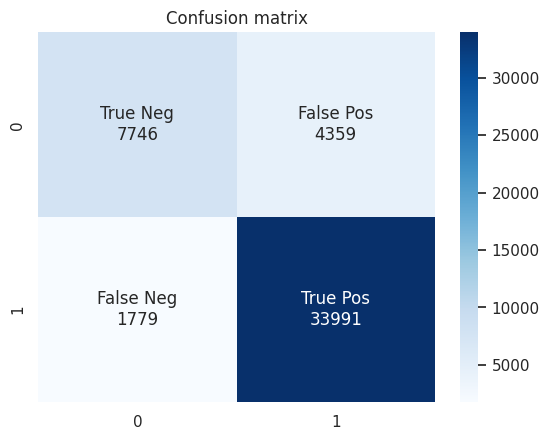

In [33]:
plot_confusion_matrix(confusion_train)

In [34]:
# Confusion Matrix for Test Data
confusion_test =metrics.confusion_matrix(y_test, y_pred_class)
print(confusion_test)

[[ 2380  1672]
 [  576 11331]]


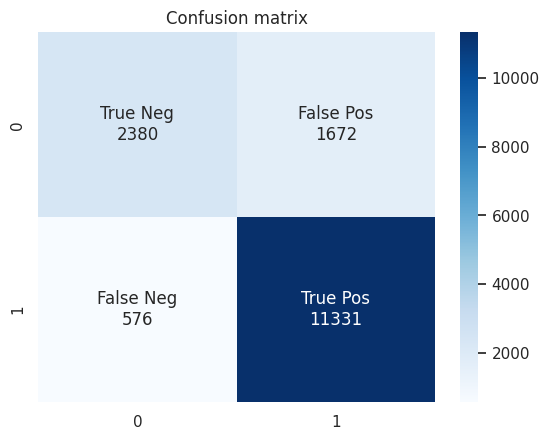

In [35]:
plot_confusion_matrix(confusion_test)

##### Metrics of the model

In [36]:
# train data
TN_train = confusion_train[0, 0]
FP_train = confusion_train[0, 1]
FN_train = confusion_train[1, 0]
TP_train = confusion_train[1, 1]

In [37]:
# test data
TN_test = confusion_test[0, 0]
FP_test = confusion_test[0, 1]
FN_test = confusion_test[1, 0]
TP_test = confusion_test[1, 1]

In [38]:
# Sensitivity
sensitivity_train = TP_train / float(FN_train + TP_train)
sensitivity_test = TP_test / float(FN_test + TP_test)
print('sensitivity for train data', sensitivity_train)
print('sensitivity for test data', sensitivity_test)

sensitivity for train data 0.9502655856863294
sensitivity for test data 0.9516250944822373


In [39]:
# Specificity
specificity_train = TN_train / float(TN_train + FP_train)
specificity_test = TN_test / float(TN_test + FP_test)
print('specificity for train data', specificity_train)
print('specificity for test data', specificity_test)

specificity for train data 0.6399008674101611
specificity for train data 0.5873642645607108


In [40]:
# Precision
precision_train = TP_train / float(TP_train + FP_train)
precision_test = TP_test / float(TP_test + FP_test)
print('precision for train data', precision_train)
print('precision for test data', precision_test)

precision for train data 0.8863363754889179
precision for test data 0.8714142890102284


In [42]:
# Recall
print('Recall Score for train data: ', metrics.recall_score(y_train, y_pred_train))
print('Recall Score for test data: ', metrics.recall_score(y_test, y_pred_class))

Recall Score for train data:  0.9502655856863294
Recall Score for test data:  0.9516250944822373


In [43]:
# F1 Score
print('F1 Score for train data: ', metrics.f1_score(y_train, y_pred_train))
print('F1 Score for test data: ', metrics.f1_score(y_test, y_pred_class))

F1 Score for train data:  0.9171883432271991
F1 Score for test data:  0.9097551184263348


In [44]:
# ROC Curve
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

In [45]:
# train data
false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, y_pred_proba_tr[:,1])
roc_auc_tr = auc(false_positive_rate_tr, true_positive_rate_tr)

In [46]:
# test data
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

In [47]:
# matrix of thresholds, tpr, fpr
pd.DataFrame({'Threshold': thresholds, 'TPR': true_positive_rate, 'FPR':false_positive_rate})

,Threshold,TPR,FPR
0,2.000000e+00,0.000000,0.000000
1,1.000000e+00,0.089611,0.005183
2,1.000000e+00,0.090283,0.005183
3,1.000000e+00,0.092635,0.005183
4,1.000000e+00,0.092887,0.005183
...,...,...,...
3216,4.044200e-32,0.999832,0.998026
3217,4.506654e-38,0.999832,0.999013
3218,2.719829e-44,0.999832,0.999506
3219,2.745697e-93,0.999832,1.000000


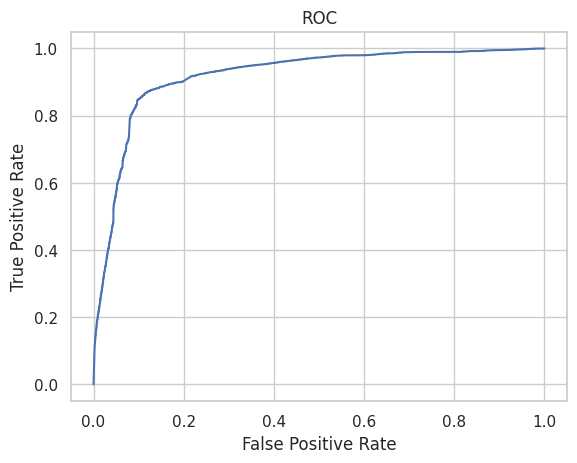

In [48]:
# plotting ROC curve for the train data
%matplotlib inline
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate_tr, true_positive_rate_tr)
plt.show()

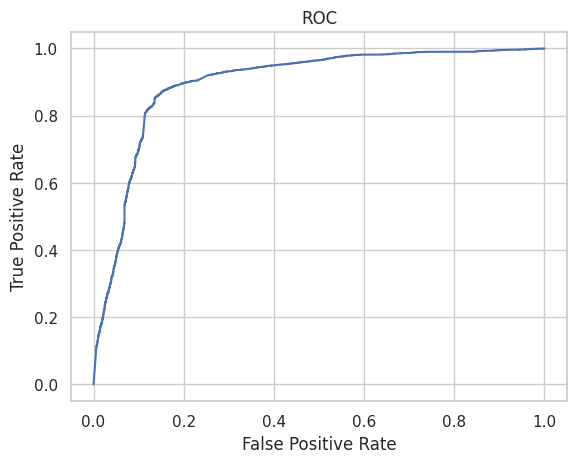

In [49]:
# plotting ROC curve for the test data
%matplotlib inline
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

As the distribution of the dataset is imbalanced with more positives, many of the reviews which were negative were incorrectly classified as positives by the NB model and hence the low specificity.
From a business point of view, this is not a good model outcome as you will miss out on the negatives.

In [50]:
# Classification reports
print("report of train data")
print(classification_report(y_train, y_pred_train))
print("report of test data")
print(classification_report(y_test, y_pred_class))

report of train data
              precision    recall  f1-score   support

           0       0.81      0.64      0.72     12105
           1       0.89      0.95      0.92     35770

    accuracy                           0.87     47875
   macro avg       0.85      0.80      0.82     47875
weighted avg       0.87      0.87      0.87     47875

report of test data
              precision    recall  f1-score   support

           0       0.81      0.59      0.68      4052
           1       0.87      0.95      0.91     11907

    accuracy                           0.86     15959
   macro avg       0.84      0.77      0.79     15959
weighted avg       0.85      0.86      0.85     15959



Model 2 - Using Oversampling

When there are more training examples in one class than another, the data is said to be skewed. This was clear from the model above's calculation of specificity. As a result, there may be bias in the decisions, which causes the classifier mistakenly chooses one class over another.

We have demonstrated the cause of the bias in the prior model and suggest to employ a technique known as Random Oversampling to address this issue. Using replacement, random oversampling selects samples at random from the minority class (in our case, 0s) and adds them to the training dataset so that the distribution of the classes is equal.

In [51]:
# splitting the data into test and train
from sklearn.model_selection  import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [52]:
pd.Series(y_train).value_counts()

review_sentiment
1    35770
0    12105
Name: count, dtype: int64

Oversampling is done only on training data -
If both the train and test data are oversampled, we may end up having same points in both the sets. So the model performance obtained cannot be reliable as the test set is not independent of the train set.

In [53]:
from imblearn import over_sampling
ros = over_sampling.RandomOverSampler(random_state=0)

In [54]:
X_train, y_train = ros.fit_resample(pd.DataFrame(X_train), pd.Series(y_train))

In [55]:
pd.Series(y_train).value_counts()

review_sentiment
1    35770
0    35770
Name: count, dtype: int64

In [58]:
# vectorizing the text
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [59]:
X_train = pd.DataFrame(X_train).iloc[:,0].tolist()

X_train[:5]

['',
 'recomend buyer quick responsable buy expect buy recomend',
 'okay battery not good',
 'excellent product love cellphone great job guy best experience phone thank',
 'request studio cellphone look like chinese smartphone review comment convince cover expectations wrong studio look great week cellphone awesome picture speed network connection lte use cellphone metro pcs t mobile check sim telcel connection recommend']

In [60]:
# Fitting X_train into the vectorizer
vect.fit(X_train)

CountVectorizer()

In [61]:
# Transforming the train and test data
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [63]:
# training the NaiveBayes model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

# Training dataset
y_pred_train = mnb.predict(X_train_transformed)
y_pred_proba_tr = mnb.predict_proba(X_train_transformed)

# Testing dataset
y_pred = mnb.predict(X_test_transformed)
y_pred_proba = mnb.predict_proba(X_test_transformed)

Evalution on Test data

In [64]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [65]:
# accuracy
from sklearn import metrics
print('Accuracy for test data: ', metrics.accuracy_score(y_test, y_pred))
print('Accuracy for train data: ', metrics.accuracy_score(y_train, y_pred_train))

Accuracy for test data:  0.8590137226643273
Accuracy for train data:  0.8723930668157674


Confusion matrix for train and test data


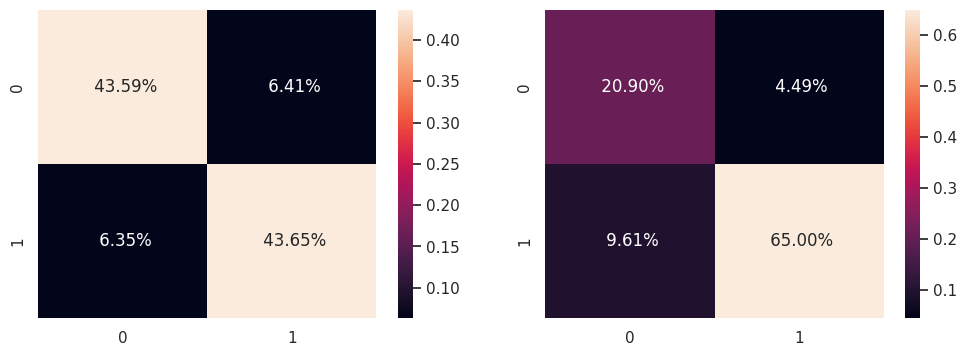

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

print('Confusion matrix for train and test data')

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
# confusion matrix for train data
cm_train = metrics.confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')

plt.subplot(1,2,2)
# confusion matrix for test data
cm_test = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()

In [67]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# test data
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

# train data
false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, y_pred_proba_tr[:,1])
roc_auc_tr = auc(false_positive_rate, true_positive_rate)

In [68]:
# area under the curve
print ('for train data:', roc_auc_tr)
print ('for test data:', roc_auc)

for train data: 0.8976378798140342
for test data: 0.8976378798140342


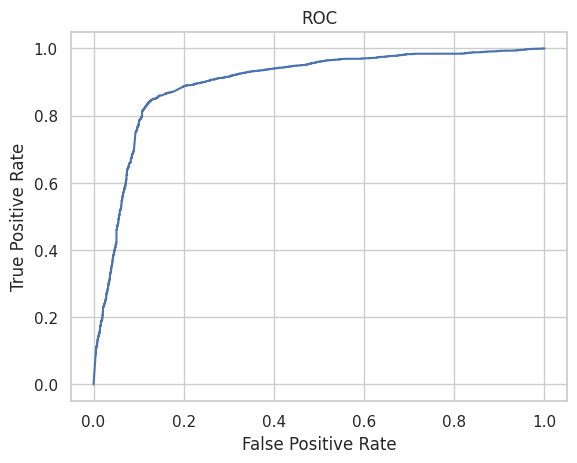

In [69]:
# plotting ROC curve for the test data
%matplotlib inline
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

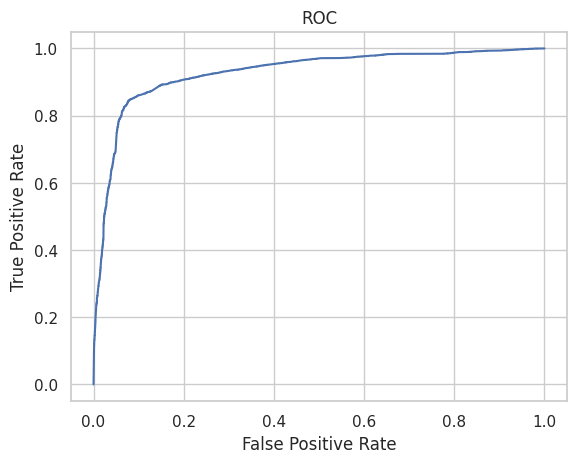

In [70]:
# plotting ROC curve for the train data
%matplotlib inline
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate_tr, true_positive_rate_tr)
plt.show()

In [71]:
# for test data
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]

# for train data
TN_tr = cm_train[0, 0]
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

In [72]:
# Specificity
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print('specificity for train data:', specificity_tr)
specificity = TN / float(TN + FP)
print('specificity for test data:', specificity)

specificity for train data: 0.8718479172490914
specificity for test data: 0.8232971372161896


In [73]:
# Sensitivity
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print('sensitivity for train data:', sensitivity_tr)
sensitivity = TP / float(FN + TP)
print('sensitivity for test data:', sensitivity)

sensitivity for train data: 0.8729382163824434
sensitivity for test data: 0.8711682203745695


In [74]:
# Classification report
print('report for train data')
print(classification_report(y_train, y_pred_train))
print('report for test data')
print(classification_report(y_test, y_pred))

report for train data
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     35770
           1       0.87      0.87      0.87     35770

    accuracy                           0.87     71540
   macro avg       0.87      0.87      0.87     71540
weighted avg       0.87      0.87      0.87     71540

report for test data
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      4052
           1       0.94      0.87      0.90     11907

    accuracy                           0.86     15959
   macro avg       0.81      0.85      0.82     15959
weighted avg       0.87      0.86      0.86     15959



The test sensitivity and specificity of the model without oversampling were 0.95 and 0.58 respectively. After oversampling model has resulted in an equal distribution of the binary labels, resulted in a jump of specificity by 0.24 with a slight decrease in the sensitivity by 0.08. From a business perspective, we can say that this is a better model when compared to the one that was built without oversampling.